In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2
from Energy.Models.Model4_population import model4_population
from Energy.Models.Model4 import model4
from Energy.Models.Model3 import model3
from Energy.Models.Model5 import model5
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_sunhours import model4_sunhours
# import importlib
# importlib.reload(Energy.Models)
# Test

If needed: Fetch energy-data first

In [2]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

100%|██████████| 274/274 [00:18<00:00, 14.62it/s]


In [3]:
# df = get_energy_data(force_return=True)
df = get_energy_data()
df = prepare_data(df)

# Cross validate baseline model

Remove everything til last thursday night 12pm

In [4]:
from datetime import datetime

# start_date_excl = most_recent_thursday(df)
# df_cval = df.loc[df.index < start_date_excl]
evaluation_date = datetime(2024,2,15)
df_cval = df.loc[df.index < evaluation_date]

Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [5]:
from HelpFunctions.mix_models import mix_models_energy


def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)        
        
        pred = None     
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else:
            pred = mix_models_energy(model['function'][0], model['function'][1], df_before)
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

## Evaluation of selected Models

In [6]:
from Energy.Models import mstl
from Energy.Models import Model5
from Energy.Models import Model1
import importlib
importlib.reload(mstl)
importlib.reload(Model5)




models = [
    {
        'name': 'baseline',
        'function': baseline
     },
    {
        'name': 'quantile regression v1',
        'function': model1
     },
    {
        'name': 'quantile regression v5',
        'function': model5
     },
    {
        'name': 'mstl',
        'function': mstl.mstl
     },
    {
        'name': 'energy ensemble',
        'function': [[mstl.mstl, model5],[1,1]]
     },
]

In [7]:
evaluate_models(models, df_cval, last_x=15, weeks=True)
# Test
# evaluate_models(models, df_cval, last_x=3, weeks=True)

*********** Start the evaluation of Model baseline ***********
Iteration 0 of 15
Iteration 1 of 15
Iteration 2 of 15
Iteration 3 of 15
Iteration 4 of 15
Iteration 5 of 15
Iteration 6 of 15
Iteration 7 of 15
Iteration 8 of 15
Iteration 9 of 15
Iteration 10 of 15
Iteration 11 of 15
Iteration 12 of 15
Iteration 13 of 15
Iteration 14 of 15
*********** Start the evaluation of Model quantile regression v1 ***********
Iteration 0 of 15
Iteration 1 of 15
Iteration 2 of 15
Iteration 3 of 15
Iteration 4 of 15
Iteration 5 of 15
Iteration 6 of 15
Iteration 7 of 15
Iteration 8 of 15
Iteration 9 of 15
Iteration 10 of 15
Iteration 11 of 15
Iteration 12 of 15
Iteration 13 of 15


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 14 of 15
*********** Start the evaluation of Model quantile regression v5 ***********
Iteration 0 of 15
Iteration 1 of 15
Iteration 2 of 15
Iteration 3 of 15


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 4 of 15
Iteration 5 of 15
Iteration 6 of 15
Iteration 7 of 15
Iteration 8 of 15
Iteration 9 of 15
Iteration 10 of 15


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 11 of 15
Iteration 12 of 15
Iteration 13 of 15
Iteration 14 of 15
*********** Start the evaluation of Model mstl ***********
Iteration 0 of 15


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Iteration 1 of 15
Iteration 2 of 15
Iteration 3 of 15
Iteration 4 of 15
Iteration 5 of 15
Iteration 6 of 15
Iteration 7 of 15
Iteration 8 of 15
Iteration 9 of 15
Iteration 10 of 15
Iteration 11 of 15
Iteration 12 of 15
Iteration 13 of 15
Iteration 14 of 15
*********** Start the evaluation of Model energy ensemble ***********
Iteration 0 of 15
Iteration 1 of 15
Iteration 2 of 15
Iteration 3 of 15


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 4 of 15
Iteration 5 of 15
Iteration 6 of 15
Iteration 7 of 15
Iteration 8 of 15
Iteration 9 of 15
Iteration 10 of 15


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 11 of 15
Iteration 12 of 15
Iteration 13 of 15
Iteration 14 of 15


### Save evaluations in pkl file

In [8]:
with open('./Model evaluations/big_ev_2.pkl', 'wb') as f:
    pickle.dump(models, f)

# with open('./Model evaluations/big_evaluation.pkl', 'rb') as f:
#     models2 = pickle.load(f)
#     models = models2

PicklingError: Can't pickle <function model5 at 0x16961c1f0>: it's not the same object as Energy.Models.Model5.model5

### Create a table that only contains the different scores of the different models

In [9]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)

### Plot the densities of the obtained scores

In [10]:
[m['name'] for m in models]

['baseline',
 'quantile regression v1',
 'quantile regression v5',
 'mstl',
 'energy ensemble']

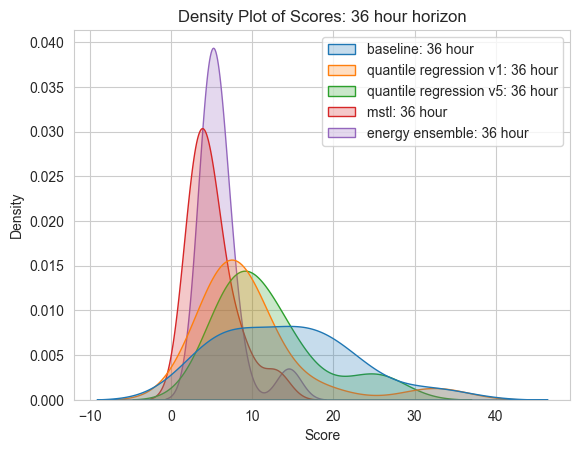

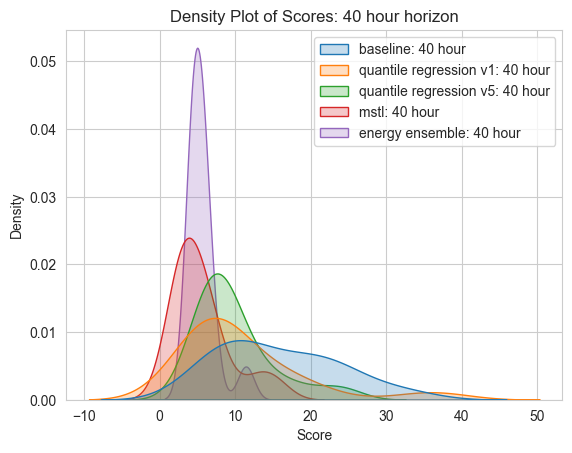

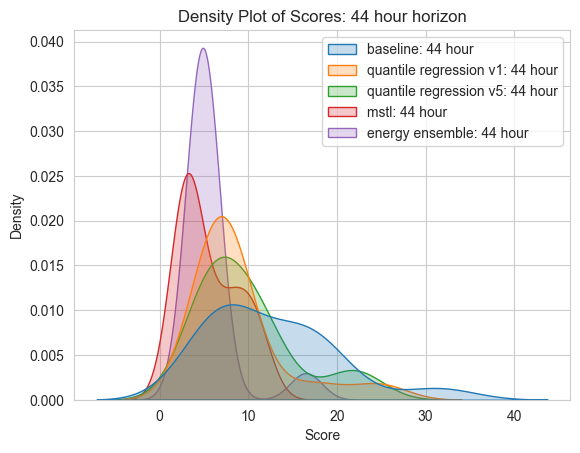

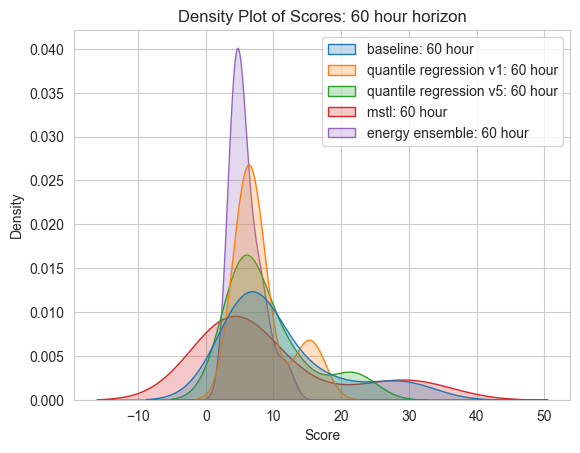

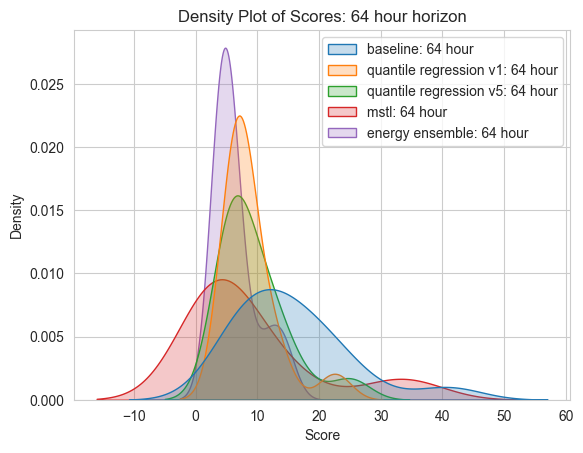

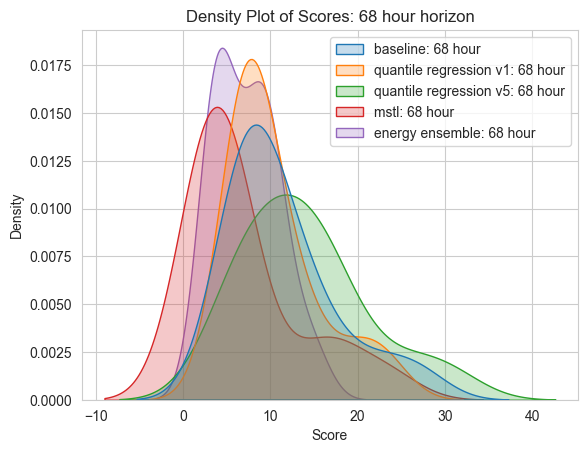

In [13]:
# models_display = ['quantile regression v5']
models_display = [m['name'] for m in models]
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # print(score_df.loc[:,[f'{m}: {h}' for m in models_display]].agg(['mean','std']))
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.savefig(f'plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()  

In [ ]:
score_mean_overview = pd.DataFrame()
score_var_overview = pd.DataFrame()
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    for m in models_display:
        score_mean_overview.loc[m,h] = score_df.loc[:,f'{m}: {h}'].mean()
        score_var_overview.loc[m,h] = score_df.loc[:,f'{m}: {h}'].var()
print(score_mean_overview)
print(score_var_overview)

In [ ]:
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    plt.figure(dpi=300)
    for c in [f'{m}: {h}' for m in models_display]:
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)
    plt.xlabel('Date')
    plt.ylabel('Quantile Score')
    plt.title(f'Comparison of scores over time: {h} horizon')
    plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.savefig(f'plots/line_plot_{h.replace(" ", "_")}.eps')
    
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

#### Plot Whole evaluation for a model

In [ ]:
[m['name'] for m in models]

In [ ]:


import matplotlib.pyplot as plt

def plot_evaluation(evaluation_data):
    # Assuming your DataFrame is named df
    numeric_columns = evaluation_data.copy().select_dtypes(include='number')
    
    # Plotting
    plt.figure(figsize=(12, 8), dpi=300)
    for column in numeric_columns.columns:
        plt.plot(evaluation_data.index, evaluation_data[column], label=column)
    
    # Adding labels and legend
    plt.xlabel('Date')
    plt.ylabel('Model score, quantile forecasts and observations of energy data')
    plt.title('Model score, quantile forecasts and observations for the final quantile regression model')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'plots/energy_baseline_absolute.eps')
    plt.show()

plot_evaluation(models[0]['evaluation'][models[0]['evaluation']['horizon'] == '40 hour'])

### Search for outliers (highest scores per horizon)

In [ ]:
models_display = ['model4_holidays_2']
horizons = [36]
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    for c in [f'{m}: {h}' for m in models_display]:
        df_sorted = score_df[c].sort_values().dropna().tail(10)
        
        
        print(f'{c}')
        print(df_sorted)

In [ ]:
[m['name'] for m in models]

In [ ]:
models[5]